<font size=6><b>**Анализ данных в индустрии 2023 (Тинькофф)**</b></font>
    
<font size=6><b>**Проект №1**</b></font>

***

# Постановка задачи

**Цель**  
Построить воронку проекта *"Тинькофф квест"*, которая показывала бы в динамике по неделям и месяцам, сколько клиентов посещает наш сайт, и какая доля из них регистрируется на нем \ подает заявку на игру \ по факту приходит на нее.
Количество клиентов и конверсии необходимо изобразить на одном графике.

**Задачи**  

1. Подключиться к базе данных. 
1. Собрать датасет с необходимыми полями.
1. Посчитать конверсии и сделать визуализацию.

**Исходные данные**  
Схема данных проекта *"Тинькофф квест"*
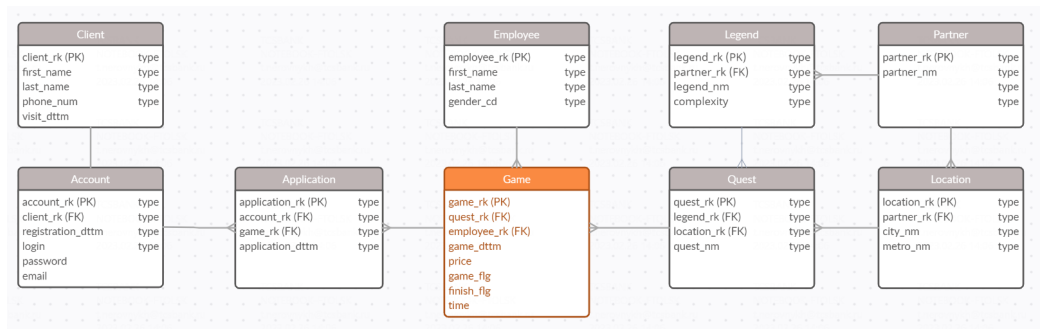


# Подготовка окружения

Загрузим библиотеки, необходимые для выполнения проекта.

In [1]:
# Нестандартные библиотеки
# !pip install psycopg2-binary
# !pip install nb-black
# !pip install -U matplotlib

In [2]:
import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import psycopg2
import seaborn as sns

%load_ext lab_black

# Подключение к базе данных

Согласно предоставленным данным подключимся к учебной БД.

In [3]:
conn = psycopg2.connect(
    host="158.160.52.106",
    port=5432,
    database="postgres",
    user="student",
    password="JvLda93aA",
)

In [4]:
def select(sql):
    return pd.read_sql(sql, conn)

Для решения поставленной задачи необходимо объединить таблицы `client_id`, `account_id`, `application_id`, `game`.

In [5]:
sql = """
WITH
games AS (
    SELECT
        g.game_rk,
        DATE(date_trunc('week', DATE(g.game_dttm))) AS game_week,
        DATE(date_trunc('month', DATE(g.game_dttm))) AS game_month
    FROM msu_analytics.game g
    WHERE g.game_flg = 1
)

SELECT 
    c.client_rk AS client_id,
    DATE(date_trunc('week', DATE(c.visit_dttm))) AS visit_week,
    DATE(date_trunc('month', DATE(c.visit_dttm))) AS visit_month,
    acc.account_rk AS account_id,
    DATE(date_trunc('week', DATE(acc.registration_dttm))) AS reg_week,
    DATE(date_trunc('month', DATE(acc.registration_dttm))) AS reg_month,
    app.application_rk AS application_id,
    DATE(date_trunc('week', DATE(app.application_dttm))) AS app_week,
    DATE(date_trunc('month', DATE(app.application_dttm))) AS app_month,
    app.game_rk AS game_id,
    g.game_week,
    g.game_month
FROM msu_analytics.client AS c
LEFT JOIN msu_analytics.account AS acc ON c.client_rk = acc.client_rk
LEFT JOIN msu_analytics.application AS app USING(account_rk)
LEFT JOIN games AS g USING(game_rk)
ORDER BY client_id, reg_week, app_week, game_week
"""

df = select(sql)

/home/deli/anaconda3/lib/python3.9/site-packages/pandas/io/sql.py:762: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


Сохраним датасет в отдельный файл на случай падения базы.

In [6]:
# df.to_csv('df.csv')

# Анализ и уточнение датасета

Выведем первые 5 строк собранных данных и общую информацию по таблице.

In [7]:
df.head()

,client_id,visit_week,visit_month,account_id,reg_week,reg_month,application_id,app_week,app_month,game_id,game_week,game_month
0,1,2022-09-26,2022-09-01,NaN,None,None,NaN,None,None,NaN,None,None
1,2,2022-10-17,2022-10-01,NaN,None,None,NaN,None,None,NaN,None,None
2,3,2022-09-19,2022-09-01,12.0,2022-09-26,2022-09-01,NaN,None,None,NaN,None,None
3,4,2022-11-28,2022-11-01,801.0,2022-11-28,2022-12-01,75.0,2022-12-05,2022-12-01,22.0,2022-12-12,2022-12-01
4,4,2022-11-28,2022-11-01,801.0,2022-11-28,2022-12-01,369.0,2022-12-12,2022-12-01,240.0,2023-01-02,2023-01-01


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4315 entries, 0 to 4314
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   client_id       4315 non-null   int64  
 1   visit_week      4315 non-null   object 
 2   visit_month     4315 non-null   object 
 3   account_id      1243 non-null   float64
 4   reg_week        1243 non-null   object 
 5   reg_month       1243 non-null   object 
 6   application_id  512 non-null    float64
 7   app_week        512 non-null    object 
 8   app_month       512 non-null    object 
 9   game_id         512 non-null    float64
 10  game_week       264 non-null    object 
 11  game_month      264 non-null    object 
dtypes: float64(3), int64(1), object(8)
memory usage: 404.7+ KB


По полученной информации видно, что в итоговой таблице большое количество пропусков, при этом количество non-null объектов соответствует количеству объектов в соответствующих таблицах БД.
Кроме того, даты импортировались с неправильным типом данных, который следует исправить для корректного построения графиков.

In [9]:
date_features = [
    "visit_week",
    "visit_month",
    "reg_week",
    "reg_month",
    "app_week",
    "app_month",
    "game_week",
    "game_month",
]

for i in date_features:
    df[i] = pd.to_datetime(df[i])

Проведем экспресс-анализ датасета и посмотрим распределение количества проведенных игр по месяцам и неделям.

In [10]:
# Количество недель и месяцев в датасете
n_weeks = df["game_week"].nunique()
n_months = df["game_month"].nunique()

In [11]:
def months_weeks_hists(features, xlabel):
    _, axs = plt.subplots(1, 2, figsize=(10, 5))

    titles = ["игр по месяцам", "игр по неделям"]
    bins = [n_months, n_weeks]

    for i in range(2):
        df[features[i]].hist(ax=axs[i], bins=bins[i], edgecolor="k")
        axs[i].set_title("Распределение " + titles[i])
        axs[i].set_xlabel(xlabel)
        axs[i].set_ylabel("Количество игр")

    plt.show()

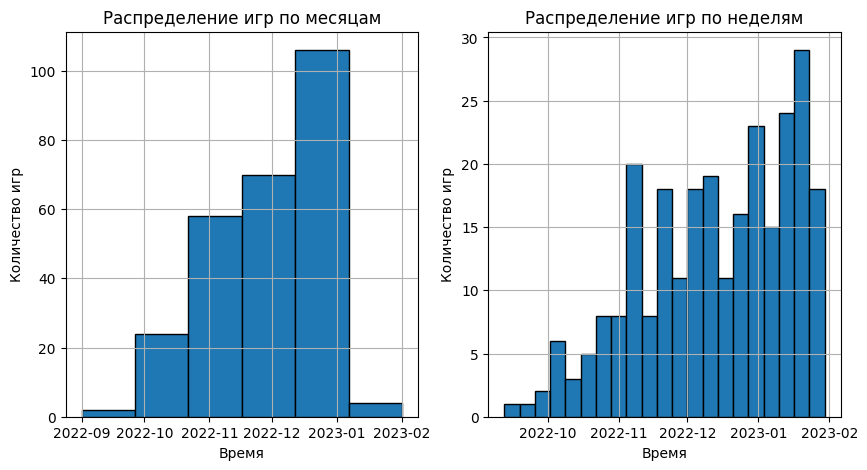

In [12]:
months_weeks_hists(
    features=["game_month", "game_week"],
    xlabel="Время",
)

Из полученных гистограмм хорошо видно, что проект *"Тинькофф квест"* находится на начальном этапе развития.
Так, в сентябре 2022 количество совершенных игр было близко к 0, а в январе 2023 уже превысило 100.

По всей видимости, база данных была сформирована в начале февраля, в результате чего в этом месяце количество игр не превосходит 10. 
С целью избежания формирования ошибочных выводов по конверсии пользователей, исключим из датасета объекты, игры по которым произошли в феврале 2023.

In [13]:
df = df.drop(df[df["game_month"] == "2023-02"].index)
df = df.drop(df[df["visit_month"] == "2023-02"].index)


n_weeks = df["game_week"].nunique()
n_months = df["game_month"].nunique()
bins = [n_months, n_weeks]

# Расчет воронки проекта

Для расчета воронки построим таблицу, сгруппированную по дате первого визита пользователя, и на ее основе - гистограммы.
Последние будут отображать конверсию пользователя от момента его визита до совершения игры.

In [14]:
def convertion_full_calc(feature):
    new_df = df.groupby(by=feature)[
        ["client_id", "account_id", "application_id", "game_week"]
    ].count()

    new_df.columns = ["client_cnt", "acc_cnt", "app_cnt", "game_cnt"]

    # new_df["cl2acc_conv"] = new_df["acc_cnt"] / new_df["client_cnt"]
    # new_df["acc2app_conv"] = new_df["app_cnt"] / new_df["acc_cnt"]
    # new_df["app2game_conv"] = new_df["game_cnt"] / new_df["app_cnt"]

    return new_df

In [15]:
conv_full_month = convertion_full_calc("visit_month")
conv_full_week = convertion_full_calc("visit_week")

In [16]:
def conversion_barpot(df, figsize, width, title):
    x = df.index
    y_1 = df["client_cnt"]
    y_2 = df["acc_cnt"]
    y_3 = df["app_cnt"]
    y_4 = df["game_cnt"]

    y_s = [y_1, y_2, y_3, y_4]
    labels = [
        "Посетители сайта",
        "Зарегистрировавшиеся посетители",
        "Заявки на игру",
        "Состоявшаяся игра",
    ]

    fig, ax = plt.subplots(figsize=figsize)
    for y in y_s:
        ax.bar(x, y, width=width)

    for bars in ax.containers:
        convertions = [f"{bars.datavalues[i] / y_1[i]:.1%}" for i in range(len(y_1))]
        ax.bar_label(bars, labels=convertions, label_type="edge", fontsize=8)

    plt.xticks(ticks=x, rotation=45)
    plt.xlabel("Даты")
    plt.ylabel("Количество")
    plt.title(title)
    ax.legend(labels, loc=(0, -0.55))
    plt.show()

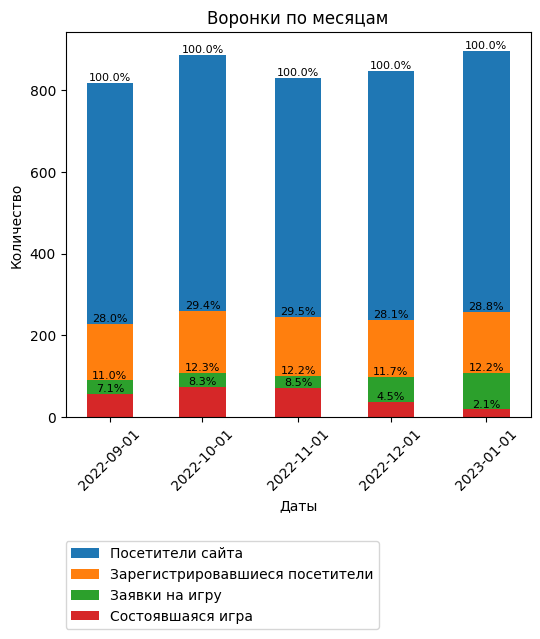

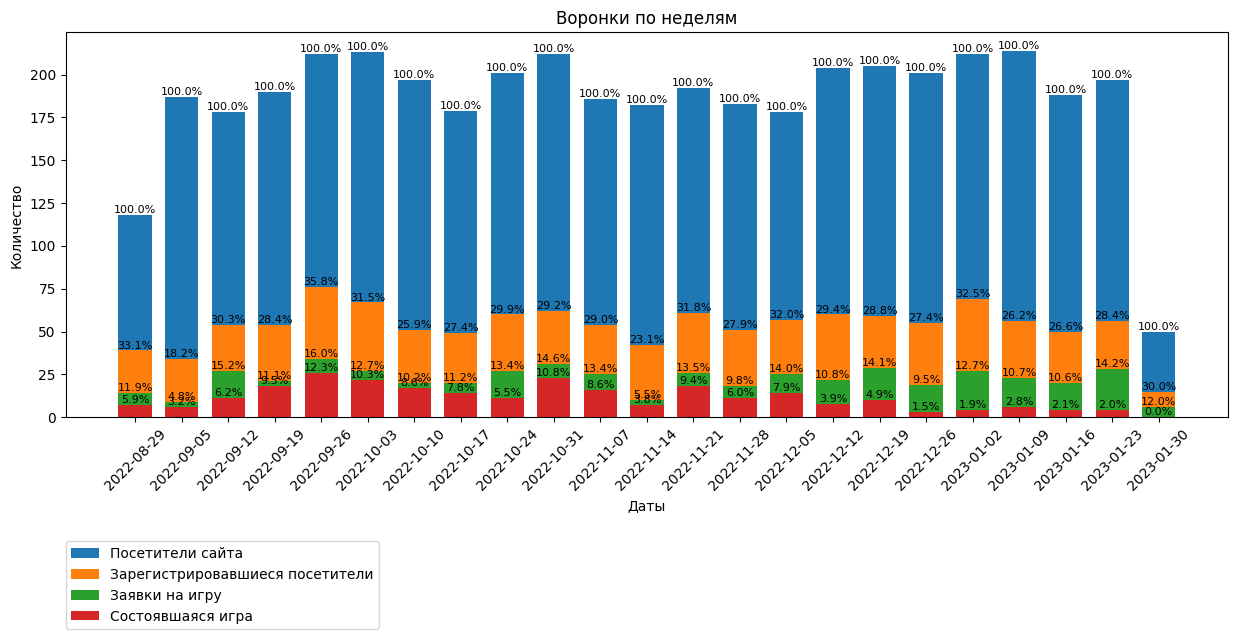

In [17]:
conversion_barpot(conv_full_month, figsize=(6, 5), width=15, title="Воронки по месяцам")
conversion_barpot(conv_full_week, figsize=(15, 5), width=5, title="Воронки по неделям")

Подписи на диаграммах соответствуют конверсии по отношению к общему числу пользователей, посетивших сайт.

Анализ воронок по месяцам позволяет сделать следующие выводы:
- Значения конверсий посетителей сайта в зарегистрировавшихся пользователей и в заявки на игру, а также абсолютные значения указанных категорий практически не изменяются в рассматриваемом интервале времени. Флуктуации значений могут быть статистически неважными;
- Конверсия посетителей в состоявшиеся игры в декабре в 2 раза меньше, чем в ноябре, а в январе - в 4 раза;
- Конверсии посетителей в зарегистрированных пользователей и из зарегистрированных пользователей в заявки на игру составляет 28...30% и 39...41% соответственно. Указанные значения представляются удовлетворительным; 
- Конверсия заявки на игру в состоявшуюся игру составляет примерно 66%, другими словами одна игра из трех отменяется. Учитывая, что именно эта конверсия, в конечном счете влияет на прибыль, ее значение представляется недостаточными.

Анализ воронок по неделям позволяет сделать следующие выводы:
- В целом, картина соответствует месячным конверсиям;
- Внутри месяца присутствует сезонность: в начале и конце наблюдается рост популярности, а в середине - ее снижение. При этом, указанное явление слабо коррелирует с конверсией посетителей в состоявшиеся игры, которая имела пик в конце сентября, после которого снижалась с  небольшими колебаниями. 

Построенные гистограммы получены при помощи группировки объектов по дате первого визита пользователя на сайт.
При этом они отображают "конечную" конверсию каждого пользователя, но не учитывают факта "отложенного платежа", который проявляется в случае если пользователь зашел на сайт в сентябре, а попал на игру в январе. 
Для анализа влияния указанного эффекта построим воронки по условию совпадения значений в поле месяца для каждой категории. 
Такие воронки соответствуют пользователям, которые посетили сайт, зарегистрировались и сходили на игру в течении 1 месяца. 

In [18]:
def convertion_current_calc(feature):
    new_df = pd.DataFrame()

    new_df["client_cnt"] = df.groupby(by=feature)[["client_id"]].count()

    def current_counts(feature_loc):
        return (
            df[df["visit_month"] == df[feature_loc]]
            .groupby(by=feature)[["client_id"]]
            .count()
        )

    new_df["acc_cnt"] = current_counts("reg_month")
    new_df["app_cnt"] = current_counts("app_month")
    new_df["game_cnt"] = current_counts("game_month")

    return new_df

In [19]:
conv_curr_month = convertion_current_calc("visit_month")
conv_curr_week = convertion_current_calc("visit_week")

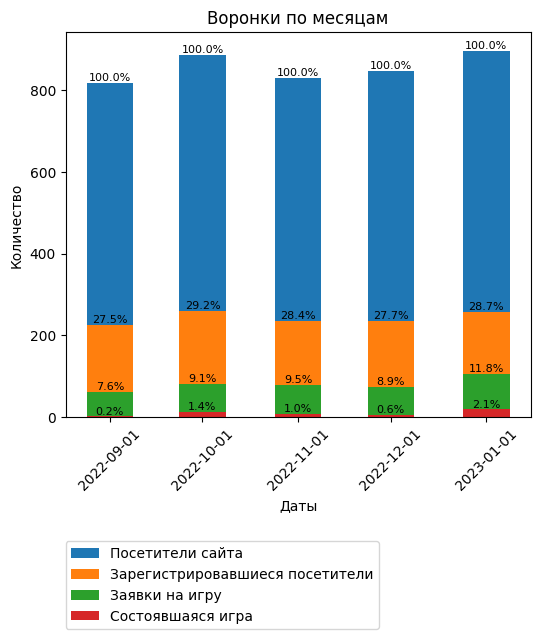

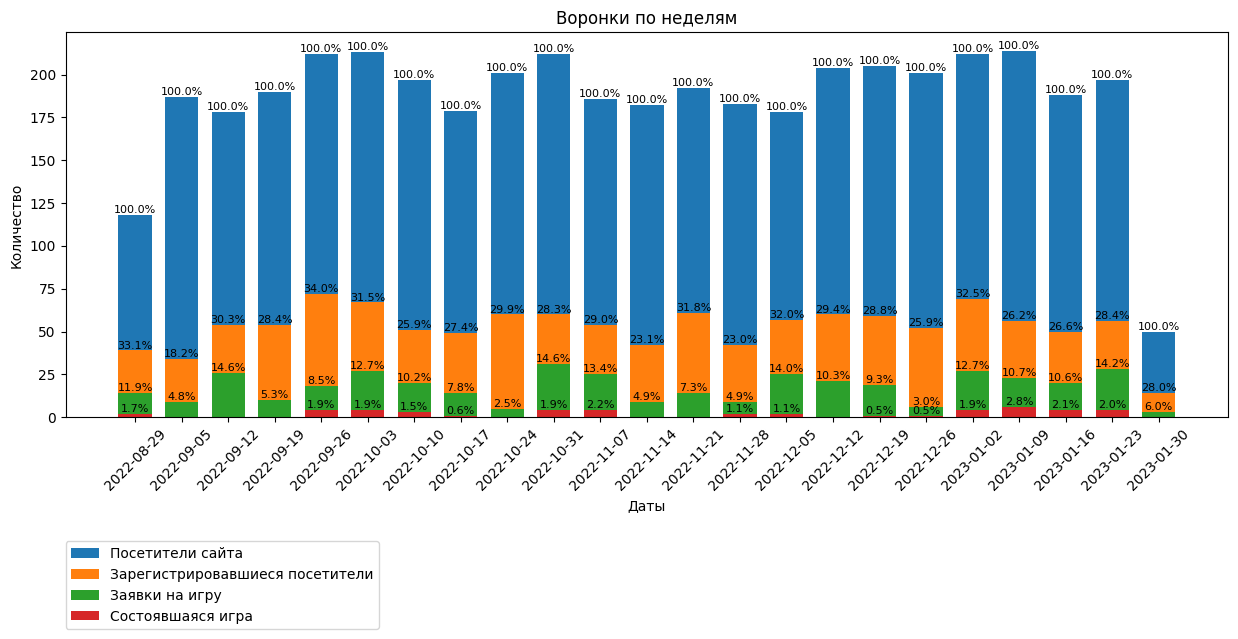

In [20]:
conversion_barpot(conv_curr_month, figsize=(6, 5), width=15, title="Воронки по месяцам")
conversion_barpot(conv_curr_week, figsize=(15, 5), width=5, title="Воронки по неделям")

По полученным гистограммам можно сделать следующие выводы:
- Конверсия посетителей сайта в зарегистрированных пользователей, в среднем, снизилась не более чем на 1-2%. Это позволяет сделать вывод, что большинство посетителей если регистрируются, то делают это практически сразу;
- Конверсия зарегистрированных пользователей в заявки на игру, в среднем, снизилась не более чем на 3-5%, что так же говорит о своевременности сделанных заказов;
- Конверсия заявок на игру в саму игру существенно упала и достигает нулевых значений. Указанный эффект означает, что пользователи записываются на игру заблаговременно и редко ходят играть сразу же после первого визита на сайт.

Для анализа последнего вывода определим задержки между первым визитом и игрой.

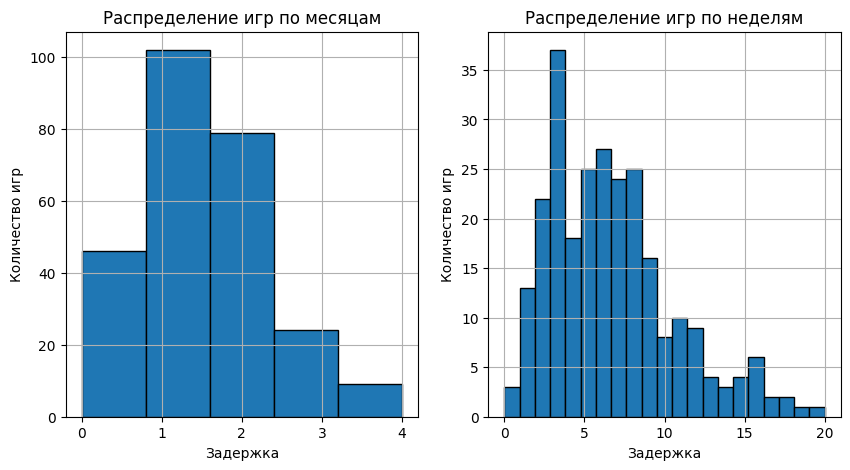

In [21]:
df["game_delay_month"] = np.ceil((df["game_month"] - df["visit_month"]).dt.days / 31)
df["game_delay_week"] = np.ceil((df["game_week"] - df["visit_week"]).dt.days / 7)

months_weeks_hists(
    features=["game_delay_month", "game_delay_week"],
    xlabel="Задержка",
)

In [22]:
df["game_delay_week"].mean()

6.523076923076923

По полученным гистограммам хорошо видно, что большая часть пользователей записываются на игры за 3 недели от момента первого визита на сайт.
При этом, в среднем, проходит 6,5 недель от момента первого посещения пользователем сайта до поступления от него денежных средств.

В этой связи рассмотрение воронок продаж по неделям и месяцам не отражает картину целиком, так как указанные периоды меньше среднего периода поступления прибыли.

# Заключение

В результате работы собран датасет, посчитаны конверсии и построены воронки проекта *"Тинькофф квест"* в разрезе по неделям и по месяцам.

Собранный датасет содержит данные с сентября 2022 по февраль 2023.
При этом, данные за последний месяц не полные, в результате чего они исключены из рассмотрения.

Анализ построенных воронок позволяет сделать следующие основные выводы:

1. Как правило, пользователи посещают сайт, регистрируются на нем и заказывают игру в течение 1 месяца. Месячная конверсия пользователей в указанные категории составляет около 29% и 12% от общего числа посетителей сайта соответственно. 
1. Конверсия заявки на игру в состоявшуюся игру составляет примерно 66%, другими словами одна игра из трех отменяется. Кроме того, от момента первого посещения пользователем сайта до его первой игры проходит, в среднем, 6,5 недель, что может влиять на низкое значение конверсии. Учитывая, что именно эта конверсия, в конечном счете влияет на прибыль, ее значение представляется недостаточными.
1. Внутри месяца присутствует сезонность: в начале и конце наблюдается рост популярности, а в середине - ее снижение.
1. Рассмотрение воронок *"Тинькофф квест"* в разрезе по неделям и месяцам не отражает картину целиком из-за длительности периода от момента первого посещения пользователем сайта до поступления от него денежных средств, превосходящей указанные интервалы.

В качестве точек роста продукта представляется целесообразным увеличение конверсии заявки на игру в состоявшуюся игру. 
Для этого необходимо подробно изучить причину длительного периода от момента первого посещения пользователем сайта до его первой игры.
Одна из возможных причин указанного явления - повышенный спрос на игры и отсутствие возможности записи на более ранний период. 
В этом случае можно вводить новые квесты или увеличивать стоимость игры в популярное время (вечером и в выходные) и снижать в менее популярное (ночь и утро).  
Кроме того, можно вводить специальные предложения, например, в виде скидки на первую игру, совершенную в течении первых двух недель после регистрации.